In [16]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
import sys
from functools import partial 
from scipy import stats, optimize
import scipy
from tqdm import tqdm
from sympy import *

## An ellipse E has semi-major axis a = 1.04 ± 0.17 and eccentricity e = 0.71 ± 0.06.
- The area A of an ellipse is generally $A = \pi a^2 \sqrt{ (1 − e^2)}$. What is the area of the ellipse E?

The Area of E can be obtained by inserting the expected values for a and e into the expression for A. Doing
so gives A(a = 1.04, e = 0.71) = 2.39.

The error on A can be obtained through either analytical error propagation or simulation of a and e values.
When using the analytical approach, we assume a Gaussian uncertainty on A and that the slope is relatively
constant over few standard deviations of a and e. As no correlation between a and e is given, it is assumed
these are uncorrelated ρae = 0. The error on A under these assumptions is given by the combination of errors
formula in Eq. 5. The expression for σA is given below.

$$\sigma(A)=\sqrt{\frac{\pi^2 a^4 e^2}{1-e^2}\sigma_e^2 + 4 \pi^2 a^2 (1-e^2) \sigma_a^2}$$

Inserting the given values for σa and σe yields $\sigma_A$ ≈ 1.3

In [17]:
def Area(a, e):
    return np.pi*a*a*np.sqrt(1 - e*e)

def Area_error(a,e,sa, se):
    return np.sqrt((np.pi**2 *a**4 *e**2)/(1 - e*e)*(se**2) + 4*np.pi**2*a*a*(1 - e*e)*(sa**2)) 

A = Area(1.04, 0.71)
A_error = Area_error(1.04, 0.71, 0.27, 0.12)
print(A, A_error, 'Standard error propagation')


2.392839699462769 1.3086861574841322 Standard error propagation


To make sure that the errors follow a gaussian distribution and the above method holds we likewise try to simulate the results by sampling (NB in the original excersise it would have given full marks to just do the error propagation. Below is just to highlight the effect. At the exam it gave extra points)

We start by sampling 10000 values of a and e from gaussian distributions. We assume that the two values are not correlated. These values are used in the formula for the area, and we create a histogram of the sampled areas. Looking at the histogram it is clear that the distribution of areas do not resemble a normal distribution, and the errorpropagation formula do not exactly hold.
Ontop of the histogram Ive also plotted the mean and error found using error propagation.

0.0963385649319485
3.441822043472743e-112 P value


C:\Users\Elias\AppData\Local\Temp\ipykernel_9344\1175303545.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.pi*a*a*np.sqrt(1 - e*e)


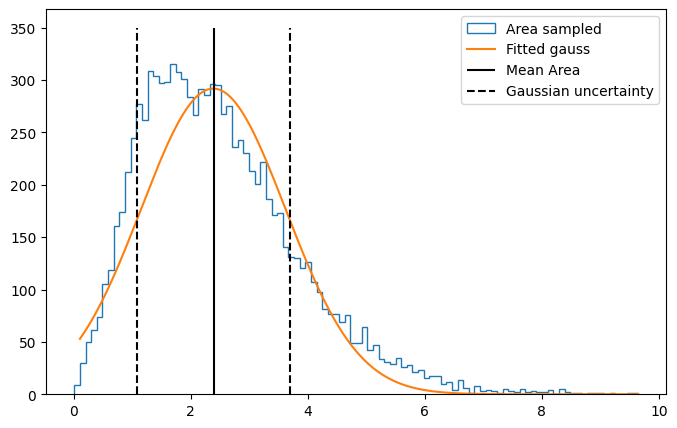

In [18]:
# Simulate values

a = np.random.normal(1.04, 0.27, 10000)
e = np.random.normal(.71, .12, 10000)
Area_sample = Area(a, e)
fig, ax = plt.subplots(1,1, figsize = (8,5))

freq, bins, _ = ax.hist(Area_sample, bins = 100, histtype = 'step', label = 'Area sampled')
bin_center = (bins[:-1] + bins[1:])/2
freq_err = np.sqrt(freq)

bw = np.diff(bins)[0]
print(bw)

bin_space = np.linspace(bins[1], bins[-1], 1000)

def gauss(x, N, mu, sigma):
    return N*stats.norm.pdf(x, loc = mu, scale = sigma)
    
chi2_fit = cost.LeastSquares(bin_center[freq > 0], freq[freq > 0], freq_err[freq >0], gauss)
chi2_fit = Minuit(chi2_fit, N = len(Area_sample)*bw, mu =np.nanmean(Area_sample), sigma = np.nanstd(Area_sample))
chi2_fit.migrad()

ax.plot(bin_space, gauss(bin_space, *chi2_fit.values[:]), label = 'Fitted gauss')


print(stats.chi2.sf(chi2_fit.fval, len(bin_center) - 3), 'P value')
ax.vlines(A, 0,350, color = 'black', label = 'Mean Area')
ax.vlines(A + A_error, 0, 350, color = 'black', ls = '--', label = 'Gaussian uncertainty')
ax.vlines(A - A_error, 0, 350, color = 'black', ls = '--')
ax.legend()


- The circumference C has no formula but can be bounded as $4a\sqrt{2 − e^2} < C < \pi a\sqrt{4 − 2e^2}$.
What value and uncertainty for C would you give?

First we compute the two bounds, and their associated errors using error propagation. we get this to the interval:
$$C \in [5.06 \pm 1.35 : 5.65 \pm 1.21]$$
One thing worth to notice is that the errors on the two bound lie within one another, aswells as the error on both bounds are larger than the interval without errors. 

Again we want to check if the errorpropagation holds. Using the same values,and the same methods as before we end up with the histogram shown below. Here both distributions look gaussian, and when fitted we get great p values. Examining the fitted mean and standard deviations, we observe that they are consistent with the results found using the analytical approach. 
Looking at the two histograms it is also easy to spot that the errors are larger than the difference between the two peaks.

In [ ]:


def upper(a,e):
    return np.pi*a*np.sqrt(4 - 2*e*e)

def lower(a,e):
    return 4*a*np.sqrt(2 - e*e)

def s_lower(a,e, sa, se):
    return np.sqrt(16 * (2 -e**2)*sa**2 + (16*a*a*e*e)/(2-e*e)*se**2)

def s_upper(a,e, sa, se):
    return np.sqrt(2*np.pi*(4 - 2*e*e)*sa**2 + (4*np.pi**2*a*a*e*e)/(4 - 2*e*e)*se**2)

C_upper = upper(1.04, .71)
C_lower = lower(1.04, .71)
sC_upper = s_upper(1.04, .71, .27, .12)
sC_lower = s_lower(1.04, .71, .27, .12)

print('Upper bound', C_upper, '$\pm$', sC_upper)
print('Lower bound', C_lower, '$\pm$', sC_lower)


upper_samples = upper(a, e)
lower_samples = lower(a, e)

fig,ax = plt.subplots(1,1, figsize = (8,5))
freq_up, bin_high, _ = ax.hist(upper_samples, bins = 100, histtype ='step')
freq_up_err = np.sqrt(freq_up)

freq_low, bin_low, _ = ax.hist(lower_samples, bins = 100, histtype ='step')
freq_low_err = np.sqrt(freq_low)

C_range = np.linspace(0, 12, 1000)

low_center = (bin_low[:-1] + bin_low[1:])/2
high_center = (bin_high[:-1] + bin_high[1:])/2
bw_high = np.diff(high_center)[0] 
bw_low = np.diff(low_center)[0] 

LC = Chi2Regression(gauss, low_center[freq_low > 0], freq_low[freq_low > 0], freq_low_err[freq_low > 0]) 
HC = Chi2Regression(gauss, high_center[freq_up > 0], freq_up[freq_up > 0], freq_up_err[freq_up > 0]) 

LC = Minuit(LC, N = len(lower_samples)*bw_low, mu = np.nanmean(lower_samples), sigma = np.nanstd(lower_samples))
LC.migrad()
HC = Minuit(HC, N = len(upper_samples)*bw_high, mu = np.nanmean(upper_samples), sigma = np.nanstd(upper_samples))
HC.migrad()

d = {
        'Circumfrence' : '',
        '$C_{upper} = $': [HC.values['mu'],HC.errors['mu']],
        '$\sigma_{C_{upper}} $ = ': [HC.values['sigma'],HC.errors['sigma']],
        '$C_{lower} = $': [LC.values['mu'],LC.errors['mu']],
        '$\sigma_{C_{lower}} $ = ': [LC.values['sigma'],LC.errors['sigma']],
        
    }

text = nice_string_output(d, extra_spacing=1, decimals=3)
add_text_to_ax(0.45, 0.5, text, ax, fontsize=10)
ax.set_xlim(0, 20)

ax.plot(C_range, gauss(C_range, *LC.values[:]))
ax.plot(C_range, gauss(C_range, *HC.values[:]))

print(stats.chi2.sf(LC.fval, len(bin_center) - 3), 'P value')
print(stats.chi2.sf(HC.fval, len(bin_center) - 3), 'P value')

print(LC.values[:])
print(HC.values[:])
fig.savefig('images/II_III_II')


ModuleNotFoundError: No module named 'probfit'